In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.image as mpimg
from subprocess import Popen
import glob,os,time,sys,math,shutil
import numpy as np
import re
import pandas as pd
from IPython.display import display,clear_output
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import seaborn as sns
import matplotlib as mpl
from scipy.stats import gaussian_kde,kde,ks_2samp,entropy
timestr=time.strftime("%m%d")
from matplotlib import colormaps
import warnings
warnings.filterwarnings('ignore')

In [2]:
!echo $PWD

/mnt/BigStorage/figs_movies_KMC/kmc_paper2025


In [3]:
df_experiment=pd.read_csv('../fig04a_hbv_assembly_w-haptamra - Sheet1.csv',skiprows=5)
df_experiment=df_experiment.dropna()

In [16]:
print(df_experiment.head())
print(df_experiment.columns)

   # dimers_t4std  counts_t4std  # dimers_highsalt  counts_highsalt  \
1         4.16667           0.0            4.16667              0.0   
2        12.50000           0.0           12.50000              0.0   
3        20.83333           0.0           20.83333              0.0   
4        29.16667           0.0           29.16667              0.0   
5        37.50000           0.0           37.50000              0.0   

   # dimers_stdsalt  counts_stdsalt  # dimers_lowsalt  counts_lowsalt  
1           6.35593             0.0              18.2         0.00000  
2          19.06780             0.0              74.6         0.00865  
3          31.77966             0.0             131.0         0.03459  
4          44.49153             0.0             187.4         0.01730  
5          57.20339             0.0             243.8         0.01441  
Index(['# dimers_t4std', 'counts_t4std', '# dimers_highsalt',
       'counts_highsalt', '# dimers_stdsalt', 'counts_stdsalt',
       '# dimer

In [5]:
def calculate_z_score(df_simulation,df_experiment,salt_conc):
    mean_simulation=df_simulation['NE'].mean()
    std_simulation=df_simulation['NE'].std()
    salt_def='# dimers_'+salt_conc
    count_def='counts_'+salt_conc
    bin_centers_std=df_experiment[salt_def]
    relative_counts_std=df_experiment[count_def]/np.sum(df_experiment[count_def])
    mean_binned = np.sum(bin_centers_std* relative_counts_std)
    std_binned = np.sqrt(np.sum(relative_counts_std * (bin_centers_std - mean_binned) ** 2))
    z_score=np.abs(mean_simulation-mean_binned)/np.sqrt(std_binned**2+std_simulation**2)
    return z_score  

In [6]:
def calculate_kl_divergence(df_simulation,df_experiment,salt_conc):
    salt_def='# dimers_'+salt_conc
    count_def='counts_'+salt_conc
    bin_centers_std=df_experiment[salt_def]
    relative_counts_std=df_experiment[count_def]/np.sum(df_experiment[count_def])
    df_simulation_filtered=df_simulation[df_simulation['NE']>50]
    #df_simulation_filtered=df_simulation
    kde = gaussian_kde(df_simulation_filtered['NE'])
    q_dist = kde(bin_centers_std)  # Evaluate KDE at bin centers
    q_dist /= np.sum(q_dist)
    a = np.asarray(relative_counts_std, dtype=float)
    b = np.asarray(q_dist, dtype=float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0)) ,q_dist


30
-21_kd-0.0001.dat
0.32895700442531256
   gdrug      kd   z_score  kl_divergence
0  -21.0  0.0001  2.173611       0.328957
-17_kd-1.0.dat
0.834583966736423
   gdrug   kd   z_score  kl_divergence
0  -17.0  1.0  3.438187       0.834584
-19_kd-0.001.dat
0.3548369679079631
   gdrug     kd   z_score  kl_divergence
0  -19.0  0.001  1.017228       0.354837
-23_kd-0.0001.dat
0.3461214459511581
   gdrug      kd   z_score  kl_divergence
0  -23.0  0.0001  1.115284       0.346121
-13_kd-0.0001.dat
17.935734286364035
   gdrug      kd  z_score  kl_divergence
0  -13.0  0.0001  2.30015      17.935734
-21_kd-1.0.dat
0.3571047747980417
   gdrug   kd   z_score  kl_divergence
0  -21.0  1.0  3.101485       0.357105
-21_kd-0.1.dat
0.3520254598203676
   gdrug   kd   z_score  kl_divergence
0  -21.0  0.1  1.089446       0.352025
-23_kd-0.1.dat
0.3814465944851659
   gdrug   kd   z_score  kl_divergence
0  -23.0  0.1  1.558576       0.381447
-13_kd-1.0.dat
0.1183805376328775
   gdrug   kd   z_score  kl_divergen

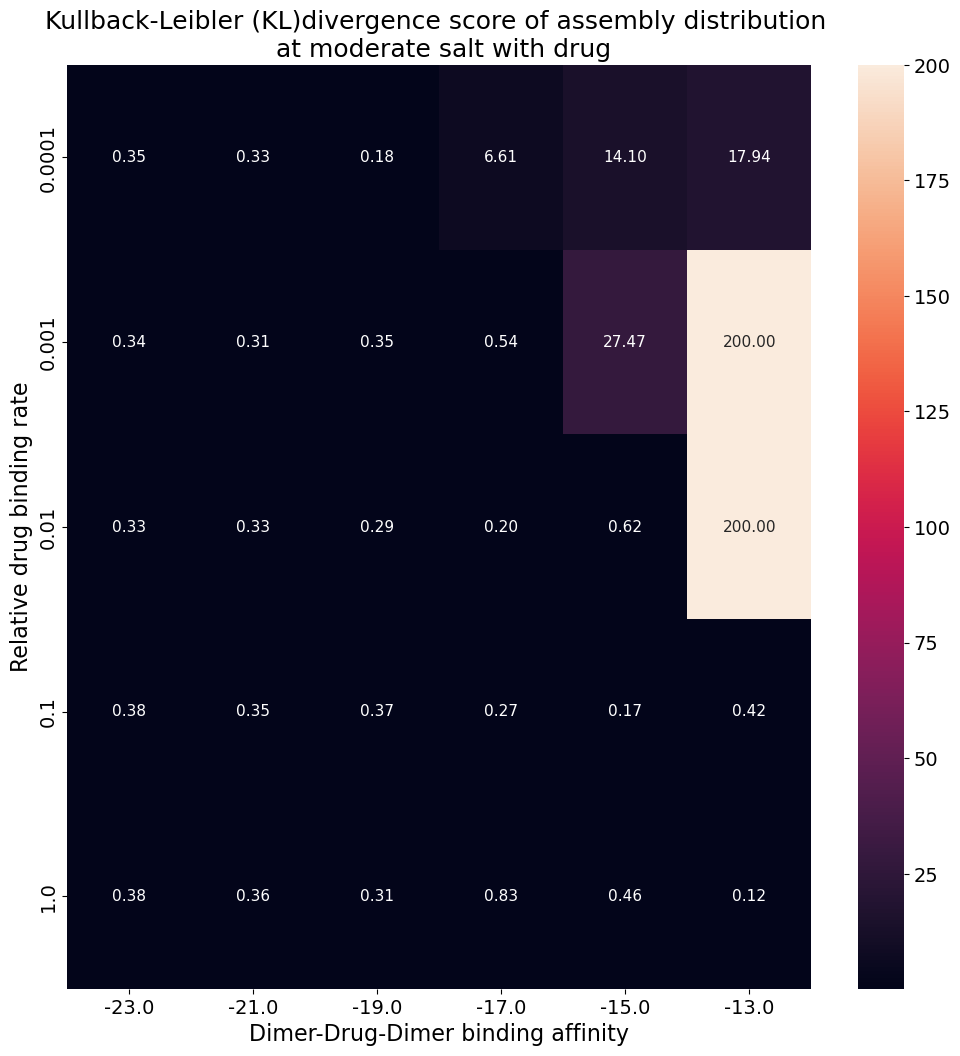

In [13]:
plot_highdata=pd.DataFrame(columns=["gdrug", "kd", "z_score","kl_divergence"])
salt_conc='stdsalt'
nfiles=glob.glob('/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/*dat')
print(len(nfiles))
for file in nfiles:
    paras=file.split("4.5_RGDRUG-")[1]
    print(paras)
    #print(paras)
    gdrug=paras.split("_")[0]
    kd=paras.split("kd-")[1]
    kd=kd.split(".dat")[0]
    if not os.path.exists(file):
        continue
    df_simulation=pd.read_csv(file)
    z_score=calculate_z_score(df_simulation,df_experiment,salt_conc)
    try:
        kl_divergence,qdist=calculate_kl_divergence(df_simulation,df_experiment,salt_conc)
        print(kl_divergence)
    except:
        pass
    if kl_divergence==np.inf:
        kl_divergence=200
    new_row = [[float(gdrug),float(kd),z_score,kl_divergence]]
    nr=pd.DataFrame(new_row,columns=['gdrug', "kd",'z_score','kl_divergence'])
    print(nr)
    plot_highdata = pd.concat([plot_highdata,nr], ignore_index=True)
plot_highdata["kl_divergence"].fillna(200, inplace=True)

plot_highdata=plot_highdata.dropna(ignore_index=True)
glue = plot_highdata.pivot_table(index="kd", columns="gdrug", values="kl_divergence",aggfunc='first')
print(glue)
fig = plt.figure(figsize=(12, 12))
#fig.suptitle('z-score of assembly size at high salt with drug',fontsize=16)

ax=sns.heatmap(glue,xticklabels=1, yticklabels=1,annot=True,annot_kws={"fontsize":11},fmt='.2f',cmap='rocket')
ax.set_title('Kullback-Leibler (KL)divergence score of assembly distribution \n at moderate salt with drug',fontsize=18)
ax.set_ylabel('Relative drug binding rate',fontsize=16)
ax.set_xlabel('Dimer-Drug-Dimer binding affinity',fontsize=16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=14)
plt.savefig('figs_kmcpaper_2025/std_drug_kl_divergence_extra.png')
plt.savefig('figs_kmcpaper_2025/std_drug_kl_divergence_extra.svg')


In [14]:
def calculate_distribution(df_simulation,df_experiment,salt_conc):
    salt_def='# dimers_'+salt_conc
    count_def='counts_'+salt_conc
    bin_centers_std=df_experiment[salt_def]
    relative_counts_std=df_experiment[count_def]/np.sum(df_experiment[count_def])
    df_simulation_filtered=df_simulation[df_simulation['NE']>50]
    kde = gaussian_kde(df_simulation_filtered['NE'])
    q_dist = kde(bin_centers_std)  # Evaluate KDE at bin centers
    q_dist /= np.sum(q_dist)
    return q_dist

In [43]:
file_dire='/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt'
sns.set_theme(style="white", palette=None)
file_list=sorted(glob.glob(file_dire+'/SE-DMU--4.5_RGDRUG--*kd-0.0001.dat'))
print(file_list)
print(len(file_list))
def size_distribution_plots(file_list,salt_conc_name):
    markerarraystd=mpl.colormaps['rocket'](np.linspace(0.35,0.9,6))
    markerarrayhigh=mpl.colormaps['ocean'](np.linspace(0,0.5,3))
    markerarraylow=mpl.colormaps['winter'](np.linspace(0.1,1,5))
    ##create a histogram of simulation data with bin centers of experimental data
    salt_def='# dimers_'+salt_conc_name
    count_def='counts_'+salt_conc_name
    bin_centers_std=df_experiment[salt_def]
    relative_counts_std=df_experiment[count_def]/np.sum(df_experiment[count_def])
    plt.figure(figsize=(12,10))
#print(file_list)
    file_numers=np.arange(len(file_list))
    #file_numers=[1,2,3]
    #file_numers=[1,2,3,4,5]
    count=0
    for file_dat in file_numers[2:]:
        kl_score=200
        df_plot=pd.read_csv(file_list[file_dat])
        print(file_list[file_dat])
        try:
            kl_score,sim_distribution=calculate_kl_divergence(df_plot,df_experiment,salt_conc_name)
            print(kl_score)
        except:
            print("didn't work")
            continue
        if kl_score==np.inf:
            kl_score=200
        kl_score=np.nan_to_num(kl_score,nan=200)
        paras=file_list[file_dat].split("4.5_RGDRUG-")[1]
    #print(paras)
        gdrug=paras.split("_")[0]
        kd=paras.split("kd-")[1]
        kd=kd.split(".dat")[0]
        print(gdrug)
        print(kl_score)
        label_name= fr'gdrug={gdrug}kT & $kl = {np.round(kl_score,2)}$'
        plt.plot(bin_centers_std,sim_distribution,linewidth=4,label=label_name,color=markerarraystd[count])
        count=count+1
    plt.plot(bin_centers_std,relative_counts_std,linestyle='--',color='darkred',label='experiment',linewidth=4)
    plt.xlabel('Shell size',fontsize=16)
    plt.ylabel('Relative frequency',fontsize=16)
    plt.title(r'Assembly size distribution at moderate salt with @$k_{dd}=0.0001$ as a function of $gdrug$',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14,loc='upper left')
    plt.savefig('figs_kmcpaper_2025/assembly_size_distribution_'+salt_conc_name+'_binding_energy.png')
    plt.savefig('figs_kmcpaper_2025/assembly_size_distribution_'+salt_conc_name+'_binding_energy.svg')
    #plt.show()



['/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--13_kd-0.0001.dat', '/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--15_kd-0.0001.dat', '/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--17_kd-0.0001.dat', '/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--19_kd-0.0001.dat', '/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--21_kd-0.0001.dat', '/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--23_kd-0.0001.dat']
6


In [19]:
df_plot=pd.read_csv('/home/smriti/BigStorage/figs_movies_KMC/new_runs_2025/allEnergyFiles/SE-DMU--4.5_Rgdrug--15_kd-0.0001.dat')
print(df_plot.head())
kl_score,sim_distribution=calculate_kl_divergence(df_plot,df_experiment,'stdsalt')
print(kl_score)
print(sim_distribution)

       sweep    seed  seconds  epsilon  kappa  kappaPhi  theta0  theta1  gb0  \
0   11850740  105419    57927   4200.0   40.0     800.0    0.24    0.48 -9.8   
1   12501466  235606   172682   4200.0   40.0     800.0    0.24    0.48 -9.8   
2  113056716  547033   172684   4200.0   40.0     800.0    0.24    0.48 -9.8   
3   14314245  618071   172679   4200.0   40.0     800.0    0.24    0.48 -9.8   
4   97707157  863087    89037   4200.0   40.0     800.0    0.24    0.48 -9.8   

     mu  ...  NVin  Nhein  NCD_T4_in   NCD_T3_in  NCD_T4  NCD_T3   Nv   NE  \
0 -11.5  ...    94    253         51           3      51       3   96  257   
1 -11.5  ...    75    198         41           4      42       4   80  208   
2 -11.5  ...   152    395         71           6      71       6  159  409   
3 -11.5  ...   118    308         56           5      59       5  125  322   
4 -11.5  ...    72    183         32           4      32       4   74  187   

   Nsurf  Nboundary  
0     31          2  
1     

In [34]:
0,1,3,-1

(0, 1, 3, -1)

/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--17_kd-0.0001.dat
6.611459369274581
-17
6.611459369274581
/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--19_kd-0.0001.dat
0.18095337031706055
-19
0.18095337031706055
/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--21_kd-0.0001.dat
0.32895700442531256
-21
0.32895700442531256
/home/smriti/BigStorage/figs_movies_KMC/parasweep_dist_stdsalt/SE-DMU--4.5_RGDRUG--23_kd-0.0001.dat
0.3461214459511581
-23
0.3461214459511581


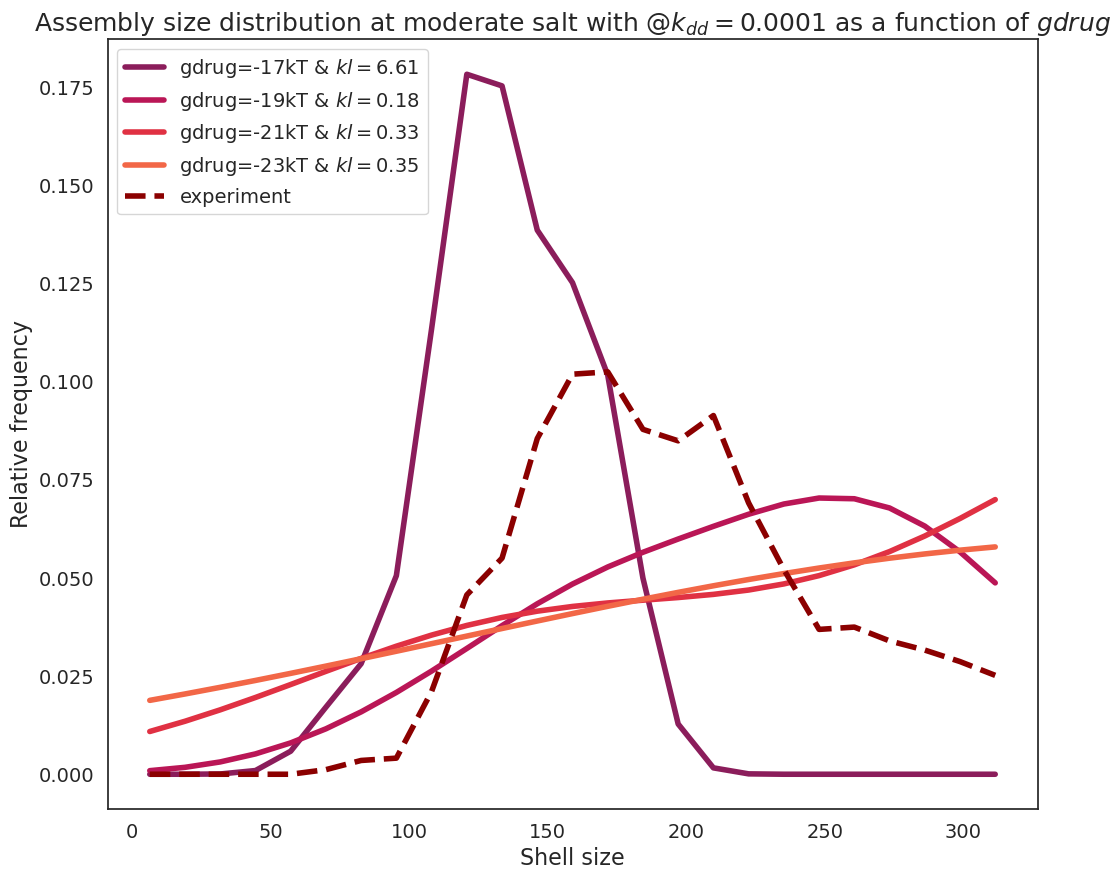

In [44]:
size_distribution_plots(file_list,'stdsalt')

In [9]:
def size_distribution_plot_single(file_list,salt_conc_name,conf_energy):
    markerarraystd=mpl.colormaps['Reds'](np.linspace(0,1,15))
    markerarrayhigh=mpl.colormaps['ocean'](np.linspace(0,0.5,3))
    markerarraylow=mpl.colormaps['winter'](np.linspace(0.1,1,5))
    ##create a histogram of simulation data with bin centers of experimental data
    salt_def='# dimers_'+salt_conc_name
    count_def='counts_'+salt_conc_name
    bin_centers_std=df_experiment[salt_def]
    relative_counts_std=df_experiment[count_def]/np.sum(df_experiment[count_def])
#print(file_list)
    #file_numers=[0,1,3,4,-1]
    #file_numers=[0,2,3]
    count=0
    for file_dat in range(len(file_list)):
        kl_score=200
        df_plot=pd.read_csv(file_list[file_dat])
        #print(df_plot.head())
        try:
            kl_score,sim_distribution=calculate_kl_divergence(df_plot,df_experiment,salt_conc_name)
            print(kl_score)
        except:
            print("didn't work")
            continue
        if kl_score==np.inf:
            kl_score=200
        kl_score=np.nan_to_num(kl_score,nan=200)
        #paras=file_list[file_dat].split(conf_energy+"_Rgdrug-")[1]
    #print(paras)
        #gdrug=paras.split("_")[0]
        #kd=paras.split("kd-")[1]
        #kd=kd.split(".dat")[0]
        #print(gdrug)
        #print(kl_score)
        #label_name= fr'kdd={kd} & $kl_{{\text{{score}}}} = {np.round(kl_score,2)}$'
        colorpalette='markerarray'+str(salt_conc_name)
        return bin_centers_std,sim_distribution,relative_counts_std,colorpalette,kl_score
  

In [11]:
file_dire='/home/smriti/BigStorage/figs_movies_KMC/new_gdrugdef'
low_salt_file=file_dire+'/highsalt.dat'
df_sim=pd.read_csv(low_salt_file)
(calculate_kl_divergence(df_sim,df_experiment,'highsalt'))
size_distribution_plot_single([low_salt_file],'highsalt',3.5)

0.1874703152102719


(1       4.16667
 2      12.50000
 3      20.83333
 4      29.16667
 5      37.50000
 6      45.83333
 7      54.16667
 8      62.50000
 9      70.83333
 10     79.16667
 11     87.50000
 12     95.83333
 13    104.16667
 14    112.50000
 15    120.83333
 16    129.16667
 17    137.50000
 18    145.83333
 19    154.16667
 20    162.50000
 21    170.83333
 22    179.16667
 23    187.50000
 24    195.83333
 25    204.16667
 Name: # dimers_highsalt, dtype: float64,
 array([1.19353256e-27, 5.69323385e-23, 9.04928342e-19, 4.79420314e-15,
        8.46992428e-12, 4.99523414e-09, 9.85529140e-07, 6.53418005e-05,
        1.47125615e-03, 1.15702985e-02, 3.49463371e-02, 5.81925495e-02,
        1.07459871e-01, 2.08217564e-01, 2.53244441e-01, 1.58244248e-01,
        6.47049219e-02, 3.81927659e-02, 2.87348817e-02, 1.27372751e-02,
        2.60599263e-03, 2.43610062e-03, 7.13279497e-03, 7.44927003e-03,
        2.59309842e-03]),
 1     0.000000
 2     0.000000
 3     0.000000
 4     0.000000
 5     0.00

0.17455426017063316
0.17455426017063316
0.15081635898399057
0.15081635898399057
0.12443243679712385
0.12443243679712385


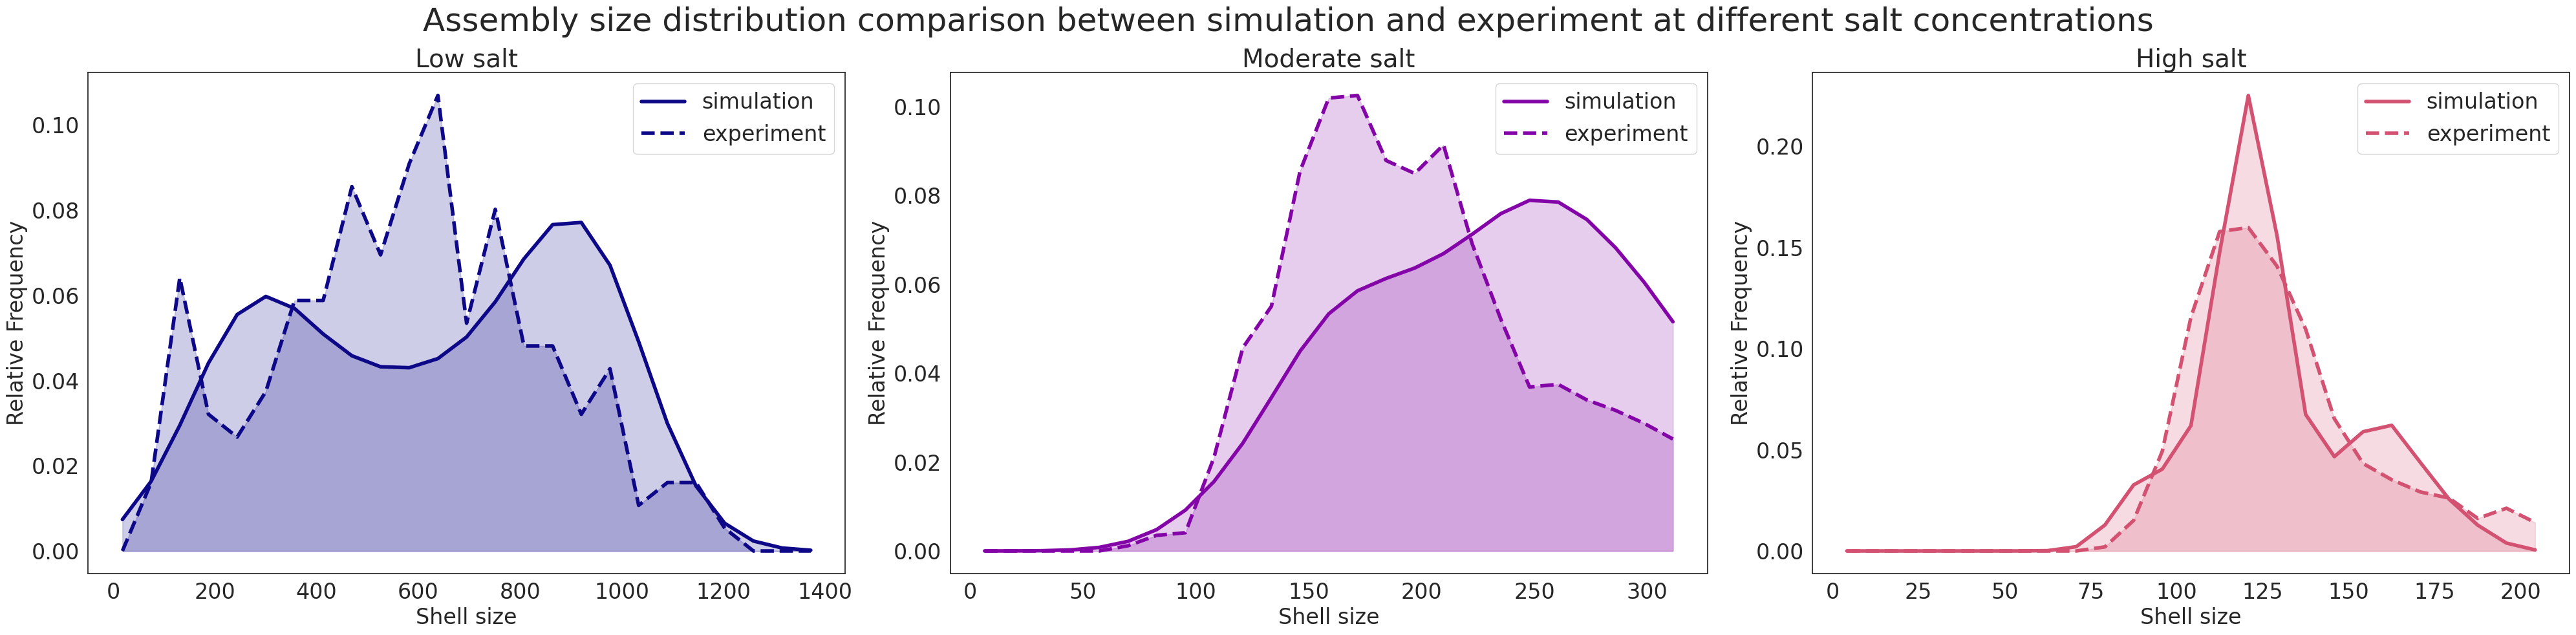

In [14]:
###subplots 3 salts with exp vs simulation

file_dire='/home/smriti/BigStorage/figs_movies_KMC/endfiles'
sns.set_theme(style="white", palette=None)
markerarraystd=mpl.colormaps['PiYG'](np.linspace(0,1,15))
markerarrayhigh=mpl.colormaps['ocean'](np.linspace(0,1.0,3))
markerarraylow=mpl.colormaps['winter'](np.linspace(0.1,1,5))
markerarray=mpl.colormaps['plasma'](np.linspace(0,0.8,4))
myarrays = {
    "markerarraystd":markerarraystd,
    "markerarrayhigh":markerarrayhigh,
    "markerarraylow":markerarraylow,
}


low_salt_file=file_dire+'/lowsalt.dat'
moderate_salt_file=file_dire+'/stdsalt.dat'
high_salt_file=file_dire+'/highsalt.dat'
salt_files=[low_salt_file,moderate_salt_file,high_salt_file]
#saltnames=['low','high','std']
saltnames=['low','std','high']
conf_energy=['5.5','4.5','3.5']
#conf_energy=['5.5','3.5','4.5']
bind_energy=['-21','-19','-17']
bincenters_exp_low,sim_salt_dist_low,relative_exp_counts_low,colorpalette_low,klscore_low= \
    size_distribution_plot_single([salt_files[0]],'lowsalt','5.5')
print(klscore_low)
bincenters_exp_std,sim_salt_dist_std,relative_exp_counts_std,colorpalette_std,klscore_std= \
    size_distribution_plot_single([salt_files[1]],'stdsalt','4.5')
print(klscore_std)
bincenters_exp_high,sim_salt_dist_high,relative_exp_counts_high,colorpalette_high,klscore_high= \
    size_distribution_plot_single([salt_files[2]],'highsalt','3.5')
print(klscore_high)
plt.rcParams['axes.labelsize'] = 22
fig, axs=plt.subplots(1,3,figsize=(40,10))

#####low salt#####
axs[0].plot(bincenters_exp_low,sim_salt_dist_low,linewidth=4,color=markerarray[0],label=fr'simulation')
axs[0].fill_between(bincenters_exp_low,sim_salt_dist_low,color=markerarray[0],alpha=0.2)
axs[0].plot(bincenters_exp_low,relative_exp_counts_low,'--',linewidth=4,color=markerarray[0],label=fr'experiment')
axs[0].fill_between(bincenters_exp_low,relative_exp_counts_low,color=markerarray[0],alpha=0.2)
axs[0].set_xlabel('Shell size',fontsize=24)
axs[0].set_ylabel('Relative Frequency',fontsize=24)
axs[0].set_title('Low salt',fontsize=28)
axs[0].legend(fontsize=24)
#######moderate salt#######
axs[1].plot(bincenters_exp_std,sim_salt_dist_std,linewidth=4,color=markerarray[1],label=fr'simulation')
axs[1].fill_between(bincenters_exp_std,sim_salt_dist_std,color=markerarray[1],alpha=0.2)
axs[1].plot(bincenters_exp_std,relative_exp_counts_std,'--',linewidth=4,color=markerarray[1],label=fr'experiment')
axs[1].fill_between(bincenters_exp_std,relative_exp_counts_std,color=markerarray[1],alpha=0.2)
axs[1].set_xlabel('Shell size',fontsize=24)
axs[1].set_ylabel('Relative Frequency',fontsize=24)
axs[1].set_title('Moderate salt',fontsize=28)
axs[1].legend(fontsize=24)
#######high salt#######
axs[2].plot(bincenters_exp_high,sim_salt_dist_high,linewidth=4,color=markerarray[2],label='simulation')
axs[2].fill_between(bincenters_exp_high,sim_salt_dist_high,color=markerarray[2],alpha=0.2)
axs[2].plot(bincenters_exp_high,relative_exp_counts_high,'--',linewidth=4,color=markerarray[2],label='experiment')
axs[2].fill_between(bincenters_exp_high,relative_exp_counts_high,color=markerarray[2],alpha=0.2)
axs[2].set_xlabel('Shell size',fontsize=24)
axs[2].set_ylabel('Relative Frequency',fontsize=24)
axs[2].set_title('High salt',fontsize=28)
axs[2].legend(fontsize=24)
fig.suptitle('Assembly size distribution comparison between simulation and experiment at different salt concentrations',fontsize=36)
for a in axs.flatten():
    a.tick_params(axis='both', labelsize=24)
plt.tight_layout()
plt.savefig('assembly_size_distribution_3salts.png')


In [11]:

def create_histogram_sim(bin_def,file_path):
    #bin2=[100+50*x for x in range(20)]
    #data=np.loadtxt(outcomefile).T
    data=np.loadtxt(file_path,delimiter=',',skiprows=1).T
    xx=[]
    for each in data[-3]:
     if 3<=each:
       xx.append(each)
    y,binEdges=np.histogram(xx,bins=bin_def)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    return bincenters,y/len(2*xx)


[  70.   90.  110.  130.  150.  170.  190.  210.  230.  250.  270.  290.
  310.  330.  350.  370.  390.  410.  430.  450.  470.  490.  510.  530.
  550.  570.  590.  610.  630.  650.  670.  690.  710.  730.  750.  770.
  790.  810.  830.  850.  870.  890.  910.  930.  950.  970.  990. 1010.
 1030. 1050. 1070. 1090. 1110. 1130. 1150. 1170. 1190. 1210. 1230. 1250.
 1270. 1290. 1310. 1330. 1350. 1370. 1390. 1410. 1430.] [0.         0.00223214 0.         0.00892857 0.00223214 0.00892857
 0.00892857 0.00446429 0.02008929 0.01116071 0.01116071 0.015625
 0.02008929 0.00669643 0.00892857 0.00892857 0.01339286 0.00892857
 0.00446429 0.00223214 0.00892857 0.00669643 0.01116071 0.00892857
 0.00446429 0.00892857 0.00669643 0.00892857 0.00446429 0.00446429
 0.01116071 0.00892857 0.00669643 0.00669643 0.01116071 0.00669643
 0.01116071 0.00892857 0.02232143 0.01339286 0.01339286 0.01116071
 0.01785714 0.02008929 0.02901786 0.015625   0.00892857 0.00892857
 0.01116071 0.00892857 0.         0.00223214 

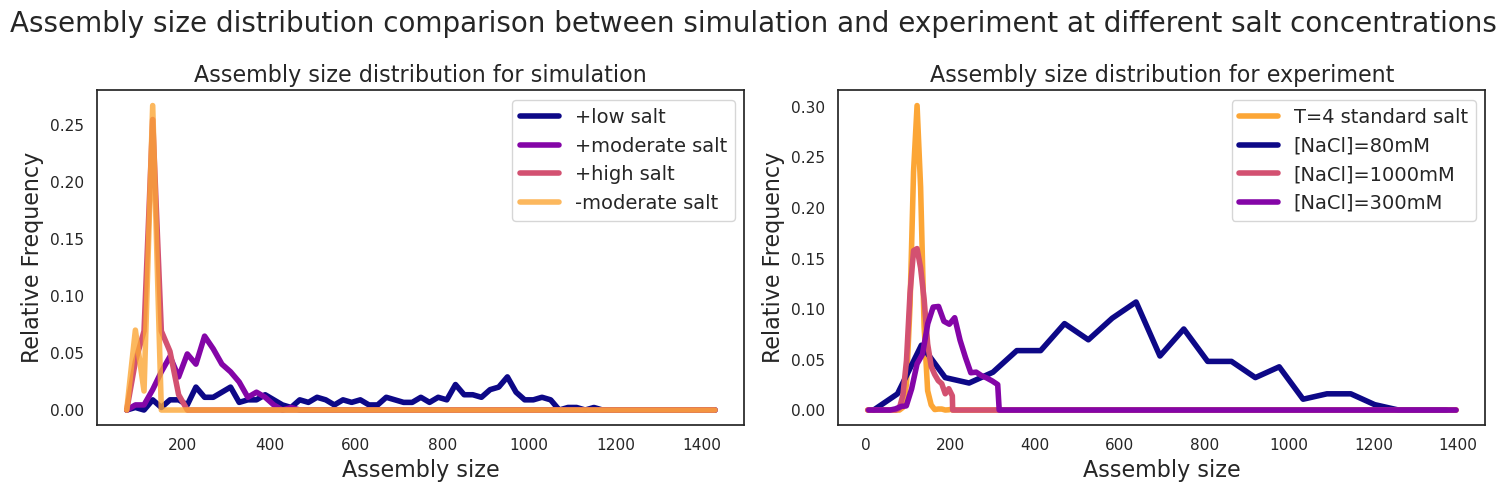

In [15]:
### exp vs simulation into two subplots
file_dire='/home/smriti/BigStorage/figs_movies_KMC/endfiles'
sns.set_theme(style="white", palette=None)
markerarraystd=mpl.colormaps['RdYlBu'](np.linspace(0.1,1,15))
markerarrayhigh=mpl.colormaps['ocean'](np.linspace(0,1.0,3))
markerarraylow=mpl.colormaps['winter'](np.linspace(0.1,1,5))
myarrays = {
    "markerarraystd":markerarraystd,
    "markerarrayhigh":markerarrayhigh,
    "markerarraylow":markerarraylow,
}



std_wo_drug_file=file_dire+'/stdsalt_wodrug.dat'
low_salt_file=file_dire+'/lowsalt.dat'
moderate_salt_file=file_dire+'/stdsalt.dat'
high_salt_file=file_dire+'/highsalt.dat'
salt_files=[low_salt_file,moderate_salt_file,high_salt_file]
#saltnames=['low','high','std']
saltnames=['low','std','high']
conf_energy=['5.5','4.5','3.5']
#conf_energy=['5.5','3.5','4.5']
bind_energy=['-21','-19','-17']




bin_list=[60+20*x for x in range(70)]
bin_centers_sim_low,y_sim_low=create_histogram_sim(bin_list,low_salt_file)
print(bin_centers_sim_low,y_sim_low)
bin_centers_sim_std,y_sim_std=create_histogram_sim(bin_list,moderate_salt_file)
bin_centers_sim_high,y_sim_high=create_histogram_sim(bin_list,high_salt_file)
print(bin_centers_sim_high,y_sim_high)
bin_centers_sim_std_wo_drug,y_sim_std_wo_drug=create_histogram_sim(bin_list,std_wo_drug_file)
plt.rcParams['axes.labelsize'] = 22
fig, axs=plt.subplots(1,2,figsize=(15,5))

##########simulation assembly size distribution at different salt concentrations#####
axs[0].plot(bin_centers_sim_low,y_sim_low,linewidth=4,color=markerarray[0],label=fr'+low salt')
axs[0].plot(bin_centers_sim_std,y_sim_std,linewidth=4,color=markerarray[1],label=fr'+moderate salt')
axs[0].plot(bin_centers_sim_high,y_sim_high,linewidth=4,color=markerarray[2],label=fr'+high salt')
axs[0].plot(bin_centers_sim_std_wo_drug,y_sim_std_wo_drug,linewidth=4,color=markerarray[3],label=fr'-moderate salt',alpha=0.8)
axs[0].set_xlabel('Assembly size',fontsize=16)
axs[0].set_ylabel('Relative Frequency',fontsize=16)
axs[0].set_title('Assembly size distribution for simulation',fontsize=16)
#axs[0].set_xlim(0,1400)
#ax[0]].set_title('Simulation assembly size distribution at different salt concentrations',fontsize=18)
axs[0].legend(fontsize=14)

##########experiment assembly size distribution at different salt concentrations#####
bin_centers_exp_t4=df_experiment['# dimers_t4std']
relative_counts_exp_t4=df_experiment['counts_t4std']/np.sum(df_experiment['counts_t4std'])
bin_centert4_array=np.array(bin_centers_exp_t4)
relative_countst4_array=np.array(relative_counts_exp_t4)
bin_center_low_array=np.array(bincenters_exp_low)
relative_countslow_array=np.array(relative_exp_counts_low)
bin_center_high_array=np.array(bincenters_exp_high)
relative_countshigh_array=np.array(relative_exp_counts_high)
bin_center_std_array=np.array(bincenters_exp_std)
relative_countstd_array=np.array(relative_exp_counts_std)

for i in range(205,1400,10):
    bin_centert4_array=np.append(bin_centert4_array,i)
    relative_countst4_array=np.append(relative_countst4_array,0)
    bin_center_high_array=np.append(bin_center_high_array,i)
    relative_countshigh_array=np.append(relative_countshigh_array,0)
for i in range(315,1400,10):
    bin_center_std_array=np.append(bin_center_std_array,i)
    relative_countstd_array=np.append(relative_countstd_array,0)
#
axs[1].plot(bin_centert4_array,relative_countst4_array,linewidth=4,color=markerarray[3],label=fr'T=4 standard salt')
axs[1].plot(bin_center_low_array,relative_countslow_array,linewidth=4,color=markerarray[0],label=fr'[NaCl]=80mM')
axs[1].plot(bin_center_high_array,relative_countshigh_array,linewidth=4,color=markerarray[2],label=fr'[NaCl]=1000mM')
axs[1].plot(bin_center_std_array,relative_countstd_array,linewidth=4,color=markerarray[1],label=fr'[NaCl]=300mM')
axs[1].set_xlabel('Assembly size',fontsize=16)
axs[1].set_ylabel('Relative Frequency',fontsize=16)
axs[1].legend(fontsize=14)
axs[1].set_title('Assembly size distribution for experiment',fontsize=16)

fig.suptitle('Assembly size distribution comparison between simulation and experiment at different salt concentrations',fontsize=20)
fig.tight_layout()
plt.savefig('assembly_exp_vs_sim.png')
plt.savefig('assembly_exp_vs_sim.svg')
#axs[0].plot(bincenters_exp_low,relative_exp_counts_low,'--',linewidth=4,color=myarrays['markerarraylow'][2],label=fr'experiment')
##axs[0].fill_between(bincenters_exp_low,relative_exp_counts_low,color=myarrays['markerarraylow'][2],alpha=0.2)
##axs[0].set_xlabel('Shell size',fontsize=24)
##axs[0].set_ylabel('Relative Frequency',fontsize=24)
##axs[0].set_title('Low salt',fontsize=28)
##axs[0].legend(fontsize=24)
#########moderate salt#######
##
##axs[1].plot(bincenters_exp_std,relative_exp_counts_std,'--',linewidth=4,color=myarrays['markerarraystd'][2],label=fr'experiment')
##axs[1].fill_between(bincenters_exp_std,relative_exp_counts_std,color=myarrays['markerarraystd'][2],alpha=0.2)
##axs[1].set_xlabel('Shell size',fontsize=24)
##axs[1].set_ylabel('Relative Frequency',fontsize=24)
##axs[1].set_title('Moderate salt',fontsize=28)
##axs[1].legend(fontsize=24)
#########high salt#######
##
##axs[2].plot(bincenters_exp_high,relative_exp_counts_high,'--',linewidth=4,color=myarrays['markerarrayhigh'][1],label='experiment')
##axs[2].fill_between(bincenters_exp_high,relative_exp_counts_high,color=myarrays['markerarrayhigh'][1],alpha=0.2)
##axs[2].set_xlabel('Shell size',fontsize=24)
##axs[2].set_ylabel('Relative Frequency',fontsize=24)
##axs[2].set_title('High salt',fontsize=28)
##axs[2].legend(fontsize=24)
##fig.suptitle('Assembly size distribution comparison between simulation and experiment at different salt concentrations',fontsize=36)
##for a in axs.flatten():
##    a.tick_params(axis='both', labelsize=24)
##plt.tight_layout()
##plt.savefig('assembly_size_distribution_3salts.png')
#

25
25
311.44068
204.16667
204.16667


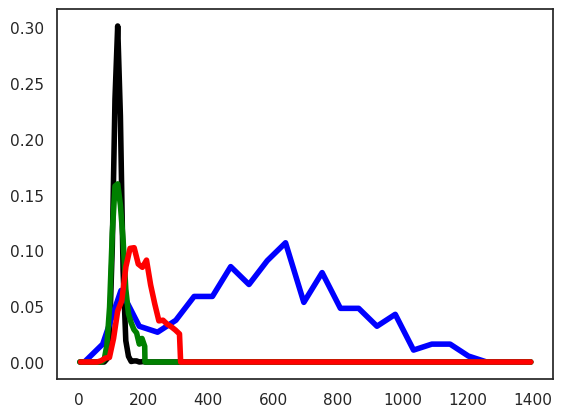

In [ ]:

plt.savefig('assembly_size_exp.png')
plt.savefig('assembly_size_exp.')

(3, 128)
(3, 128)
(3, 128)


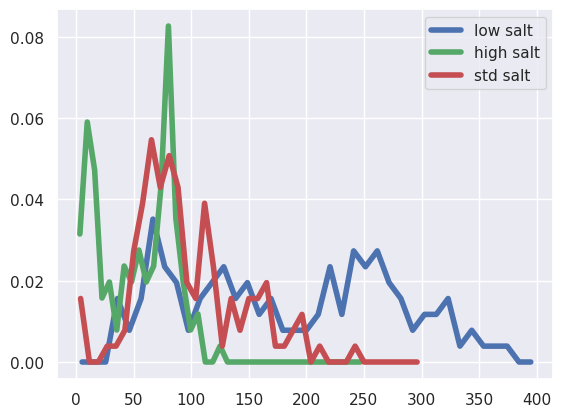

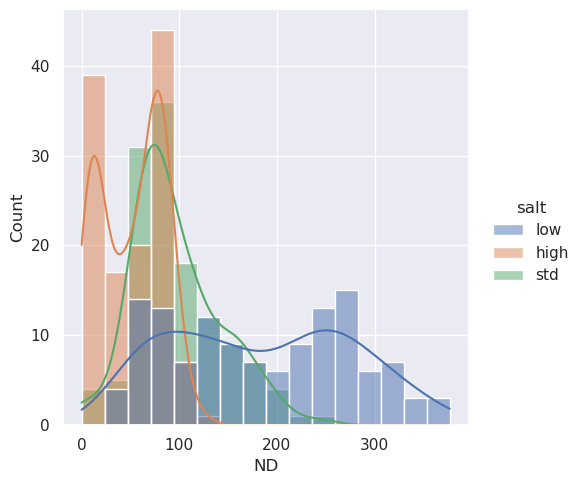

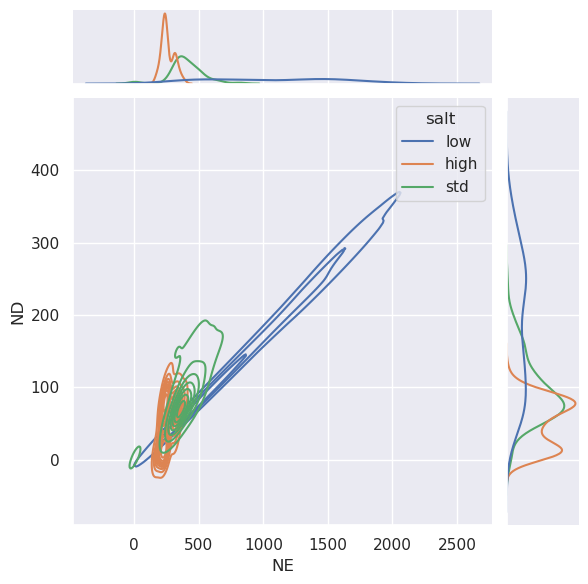

In [59]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter
sns.set_theme()
def create_histogram_drug(bin_def,file_path):
    #bin2=[100+50*x for x in range(20)]
    #data=np.loadtxt(outcomefile).T
    data=np.loadtxt(file_path,delimiter=' ').T
    print(data.shape)
    xx=[]
    for each in data[-1]:
     if 0<each:
       xx.append(each)
    y,binEdges=np.histogram(xx,bins=bin_def)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    return bincenters,y/len(2*xx)
files_low_salt_drug='../new_runs_2025/nd_calc/lowsalt_nd.dat'
files_high_salt_drug='../new_runs_2025/nd_calc/highsalt_nd.dat'
files_std_salt_drug='../new_runs_2025/nd_calc/stdsalt_nd.dat'
bin_def_low=np.linspace(0,400,40)
bin_def_high=np.linspace(0,250,40)
bin_def_std=np.linspace(0,300,40)
bin_centers_low,y_low=create_histogram_drug(bin_def_low,files_low_salt_drug)
bin_centers_high,y_high=create_histogram_drug(bin_def_high,files_high_salt_drug)
bin_centers_std,y_std=create_histogram_drug(bin_def_std,files_std_salt_drug)
plt.plot(bin_centers_low,y_low,linewidth=4,color='b',label=fr'low salt')
plt.plot(bin_centers_high,y_high,linewidth=4,color='g',label=fr'high salt')
plt.plot(bin_centers_std,y_std,linewidth=4,color='r',label=fr'std salt')
plt.legend()
plt.show()



df_low_salt_drug=pd.read_csv(files_low_salt_drug,delim_whitespace=True,header=None)
df_low_salt_drug.columns=['SWEEP','NE','ND']
df_high_salt_drug=pd.read_csv(files_high_salt_drug,delim_whitespace=True,header=None)
df_high_salt_drug.columns=['SWEEP','NE','ND']
df_std_salt_drug=pd.read_csv(files_std_salt_drug,delim_whitespace=True,header=None)
df_std_salt_drug.columns=['SWEEP','NE','ND']
for i in range(len(df_low_salt_drug)):
  df_low_salt_drug['salt']='low'
for i in range(len(df_high_salt_drug)):
  df_high_salt_drug['salt']='high'
for i in range(len(df_std_salt_drug)):
  df_std_salt_drug['salt']='std'
df_all_salt=pd.concat([df_low_salt_drug,df_high_salt_drug,df_std_salt_drug])
axs=sns.displot(data=df_all_salt,x='ND',hue='salt',kde=True)
plt.show()
sns.jointplot(
    data=df_all_salt,
    x="NE", y="ND", hue="salt",
    kind="kde",linewidth=4
)









0.1297484282121007
-15
0.1297484282121007
0.1297484282121007
[0.15294118 0.39215686 0.09803922 1.        ]


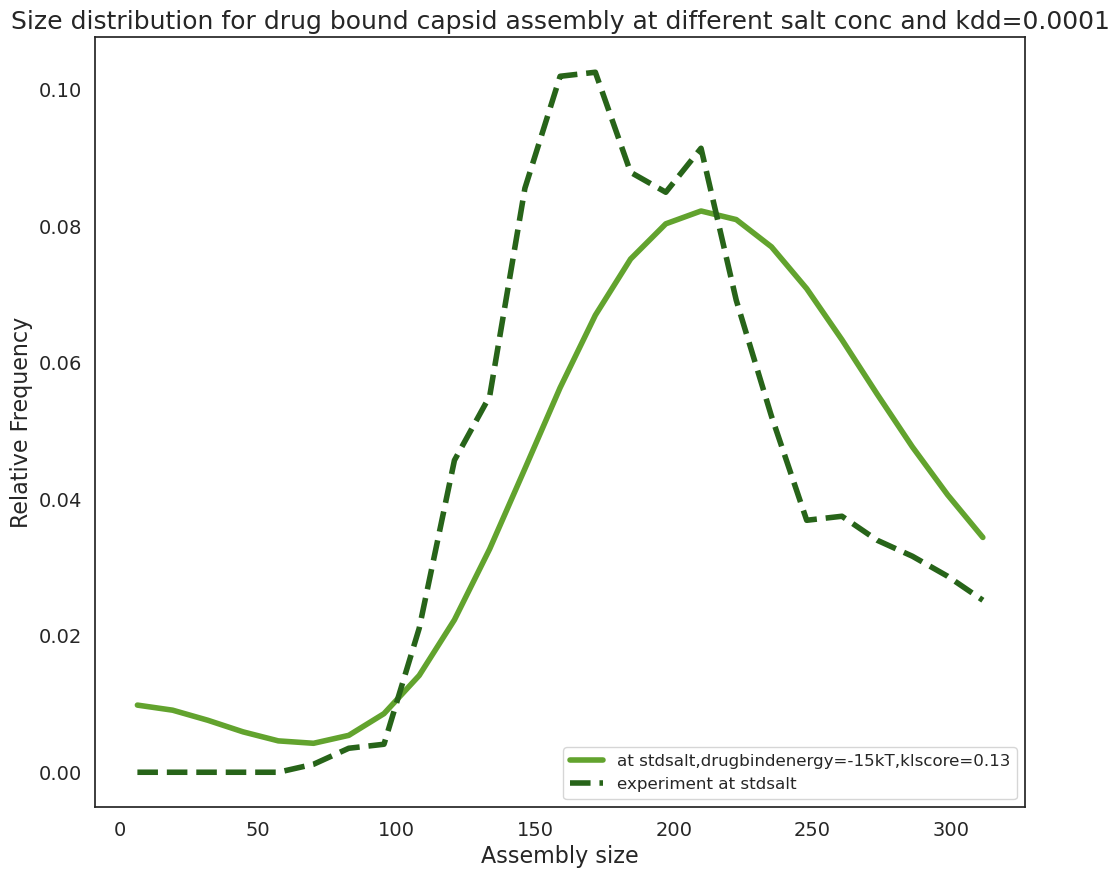

In [ ]:
###subplots 3 salts with exp vs simulation

file_dire='/home/smriti/BigStorage/figs_movies_KMC/new_runs_2025/allEnergyFiles'
sns.set_theme(style="white", palette=None)
markerarraystd=mpl.colormaps['PiYG'](np.linspace(0,1,15))
markerarrayhigh=mpl.colormaps['ocean'](np.linspace(0,0.5,3))
markerarraylow=mpl.colormaps['winter'](np.linspace(0.1,1,5))
myarrays = {
    "markerarraystd":markerarraystd,
    "markerarrayhigh":markerarrayhigh,
    "markerarraylow":markerarraylow,
}

low_salt_file=file_dire+'/SE-DMU--5.5_Rgdrug--17_kd-0.0001.dat'
moderate_salt_file=file_dire+'/SE-DMU--4.5_Rgdrug--15_kd-0.0001.dat'
high_salt_file=file_dire+'/SE-DMU--4.5_Rgdrug--13_kd-0.0001.dat'
salt_files=[low_salt_file,moderate_salt_file,high_salt_file]
#saltnames=['low','high','std']
saltnames=['low','std','high']
conf_energy=['5.5','4.5','3.5']
#conf_energy=['5.5','3.5','4.5']
bind_energy=['-17','-15','-13']
fig, axs=plt.subplots(2,2,figsize=(10,8))

for i in range(1,2):
    file_name=salt_files[i]
    bincenters_exp,sim_salt_dist,relative_exp_counts,colorpalette,klscore= \
    size_distribution_plot_single([file_name],saltnames[i],conf_energy[i])
    colorpalette=myarrays[str(colorpalette)]
    print(klscore)
    print(colorpalette[-1])
    plt.plot(bincenters_exp,sim_salt_dist,linewidth=4,label=f'at {saltnames[i]}salt,drugbindenergy={bind_energy[i]}kT,klscore={np.round(klscore,2)}',color=colorpalette[12*i])
    plt.plot(bincenters_exp,relative_exp_counts,linestyle='--',color=colorpalette[-1],label=f'experiment at {saltnames[i]}salt',linewidth=4)
plt.xlabel('Assembly size',fontsize=16)
plt.ylabel('Relative Frequency',fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Size distribution for drug bound capsid assembly at different salt conc and kdd=0.0001' ,fontsize=18)
plt.savefig('final_distribution.png')



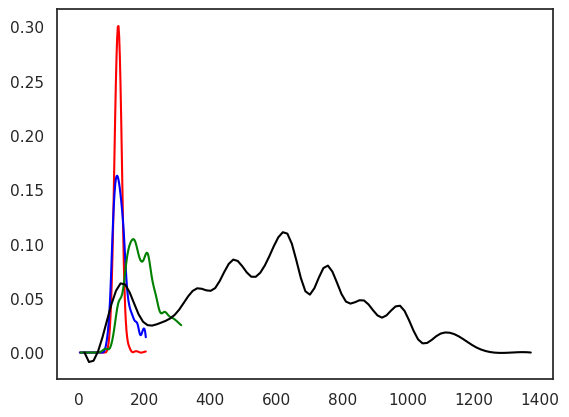

In [419]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.interpolate import interp1d
# Example binned data (bin edges and relative counts)
#bin_edges = np.array([0, 1, 2, 3, 4, 5])  # Define bin edges
#relative_counts = np.array([0.1, 0.2, 0.3, 0.25, 0.15])  # Example relative frequencies
bin_centers_std=df_experiment['# dimers_t4std']
relative_counts_std=df_experiment['counts_t4std']
pdf_binned_std = relative_counts_std / np.sum(relative_counts_std)
bin_centers_highsalt=df_experiment['# dimers_highsalt']
relative_counts_highsalt=df_experiment['counts_highsalt']
pdf_binned_highsalt = relative_counts_highsalt / np.sum(relative_counts_highsalt)
bin_centers_std_salt=df_experiment['# dimers_stdsalt']
relative_counts_std_salt=df_experiment['counts_stdsalt']
pdf_binned_std_salt = relative_counts_std_salt / np.sum(relative_counts_std_salt)
bin_centers_lowsalt=df_experiment['# dimers_lowsalt']
relative_counts_lowsalt=df_experiment['counts_lowsalt']
pdf_binned_lowsalt = relative_counts_lowsalt / np.sum(relative_counts_lowsalt)
interp_pdf = interp1d(bin_centers_std, pdf_binned_std, kind="cubic", fill_value="extrapolate")
x_fine = np.linspace(min(bin_centers_std), max(bin_centers_std), 100)
pdf_fine_std = interp_pdf(x_fine)
plt.plot(x_fine, pdf_fine_std, label="Interpolated t4std Distribution", color="red")
interp_pdf = interp1d(bin_centers_highsalt, pdf_binned_highsalt, kind="cubic", fill_value="extrapolate")
x_fine = np.linspace(min(bin_centers_highsalt), max(bin_centers_highsalt), 100)
pdf_fine_highsalt = interp_pdf(x_fine)
plt.plot(x_fine, pdf_fine_highsalt, label="Interpolated highsalt Distribution", color="blue")
interp_pdf = interp1d(bin_centers_std_salt, pdf_binned_std_salt, kind="cubic", fill_value="extrapolate")
x_fine = np.linspace(min(bin_centers_std_salt), max(bin_centers_std_salt), 100)
pdf_fine_std_salt = interp_pdf(x_fine)
plt.plot(x_fine, pdf_fine_std_salt, label="Interpolated stdsalt Distribution", color="green")
interp_pdf = interp1d(bin_centers_lowsalt, pdf_binned_lowsalt, kind="cubic", fill_value="extrapolate")
x_fine = np.linspace(min(bin_centers_lowsalt), max(bin_centers_lowsalt), 100)
pdf_fine_lowsalt = interp_pdf(x_fine)
plt.plot(x_fine, pdf_fine_lowsalt, label="Interpolated lowsalt Distribution", color="black")   
# Example raw data distribution



In [2]:
def calc_mean(df):
    avg_NE=df['NE'].sum()/(len(df))
    return avg_NE
def calc_varianvce(df):
    var_NE=df['NE'].var()
    return var_NE
def calc_std(df):
    std_NE=df['NE'].std()
    return std_NE
def calc_rmse_meanNE(df):
    return calc_std(df)/(np.sqrt(len(df.shape[0])))
def T4_count(df):
    if len(df['NE'])==0:
        count_T4=0
    else:
        count_T4=df['NE'].value_counts().get(120, 0)/len(df['NE'])
    return count_T4
def Ncurv(df):
    df['ncurv']=df['NAB'].div(df['NE'])
    return df['ncurv'].mean()
def NCD_Hex_mean(df):
    df['NCD']=df['NCD_T4']+df['NCD_T3']+df['NCD_Hex']
    df['NCD_ratio']=df['NCD_Hex'].div(df['NCD'])
    return df['NCD_ratio'].mean()
def NCD_Hex_std(df):
    df['NCD']=df['NCD_T4']+df['NCD_T3']+df['NCD_Hex']
    df['NCD_ratio']=df['NCD_Hex'].div(df['NCD'])
    return df['NCD_ratio'].std()
def T3_count(df):
    count_T3=df['NE'].value_counts().get(90, 0)/len(df['NE'])
    return count_T3

In [4]:
filenames_all=glob.glob("/scratch/09816/smritipradhan/start_pack/allEnergyFiles/*dat")
#print(filenames_all)
plot_heatdata=pd.DataFrame(columns=["gdrug", "kd", "NE_variable"])
for file in filenames_all:
    #print(file)
    paras=file.split("3.5_Rgdrug-")[1]
    #print(paras)
    gdrug=paras.split("_")[0]
    datafile0=pd.read_csv(file)
    #print(datafile0['NE'].iloc[i].type)
    datafile0=datafile0.drop(datafile0[datafile0['NE']==3].index)
    print(datafile0['NE'].dtype)
    kd=paras.split('kd-')[1]
    #print(kd)
    kd_final=kd.split(".dat")[0]
    #print(sum)
    #print(datafile0.head())
    mean_edge=calc_mean(datafile0)
    #print(mean_edge/len(datafile0))
    mean_NE_std=calc_std(datafile0)
    NCD_hexratio=NCD_Hex_mean(datafile0)
    t4percent=T4_count(datafile0)
    new_row = [[float(gdrug),float(kd_final),mean_edge]]
    nr=pd.DataFrame(new_row,columns=['gdrug', "kd",'NE_variable'])
    plot_heatdata = pd.concat([plot_heatdata,nr], ignore_index=True)
print(plot_heatdata.head())
#plot_heatdata=plot_heatdata.groupby('kd').agg({'NE_variable':'mean'}).reset_index()
print(plot_heatdata)
plot_linearkd=plot_heatdata.groupby('kd').agg({'NE_variable':'mean'}).reset_index()
plot_lineargb=plot_heatdata.groupby('gdrug').agg({'NE_variable':'mean'}).reset_index()




NameError: name 'glob' is not defined

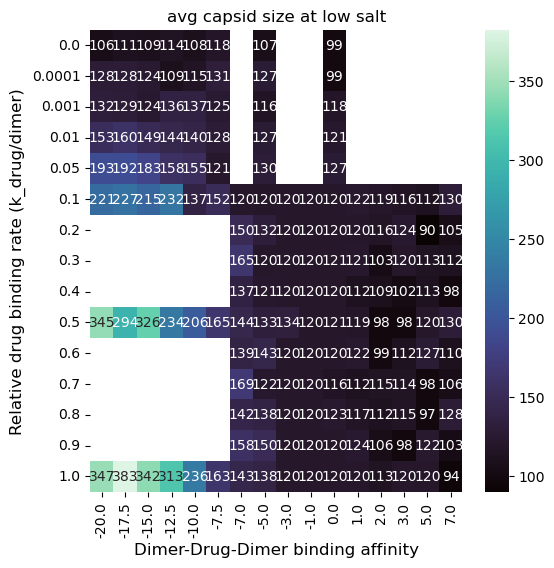

In [8]:
#plot_heatdata['kd']=plot_heatdata['gdrug']
#print(plot_heatdata)
glue = plot_heatdata.pivot(index="kd", columns="gdrug", values="NE_variable")
fig = plt.figure(figsize=(6, 6))
ax=plt.axes()
sns.heatmap(glue,ax=ax,xticklabels=1, yticklabels=1,annot=True,annot_kws={"fontsize":10},fmt='.0f',cmap='mako')
ax.set_title('avg capsid size at low salt',fontsize=12)
ax.set_ylabel('Relative drug binding rate (k_drug/dimer)',fontsize=12)
ax.set_xlabel('Dimer-Drug-Dimer binding affinity',fontsize=12)
plt.savefig('std_dev_std_salt.png')


In [23]:
stdsaltfiles=glob.glob("/scratch/09816/smritipradhan/low_salt/allEnergyFiles/*kd-0.8*.dat")
def obtain_plot_df(filelist,conf_energy):
    plot_highdata=pd.DataFrame(columns=["gdrug", "kd", "edgemean","calcstd","edgestd","t4ratio","NCDHexratio","NCDHexstd","Ncurv"])
    for file in filelist:
        paras=file.split(str(conf_energy)+"_Rgdrug-")[1]
    #print(paras)
        gdrug=paras.split("_")[0]
        datafile0=pd.read_csv(file)
    #print(datafile0['NE'].iloc[i].type)
    #datafile0=datafile0.drop(datafile0[datafile0['NE']==3].index)
        kd=paras.split('kd-')[1]
    #print(kd)
        kd_final=kd.split(".dat")[0]
        mean_edge=calc_mean(datafile0)
        mean_NE_std=calc_std(datafile0)/(np.sqrt(len(datafile0['NE'])))
        NCD_hexratio=NCD_Hex_mean(datafile0)
        NCD_hexratiostd=NCD_Hex_std(datafile0)/(np.sqrt(len(datafile0['NE'])))
        t4percent=T4_count(datafile0)
        calc_std2=calc_std(datafile0)
        curvature=Ncurv(datafile0)
        new_row = [[float(gdrug),float(kd_final),mean_edge,calc_std2,mean_NE_std,t4percent,NCD_hexratio,NCD_hexratiostd,curvature]]
        nr=pd.DataFrame(new_row,columns=['gdrug', "kd",'edgemean', "calcstd",'edgestd','t4ratio','NCDHexratio','NCDHexstd','Ncurv'])
        plot_highdata = pd.concat([plot_highdata,nr], ignore_index=True)
    return plot_highdata
plot_highdata=obtain_plot_df(stdsaltfiles,5.5)


/tmp/ipykernel_37573/2353412774.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_highdata = pd.concat([plot_highdata,nr], ignore_index=True)


In [26]:
def plot_dataframe(plot_highdata,xvariable,markerarraystd,labelname):
    plot_highdata=plot_highdata.sort_values(str(xvariable))


#axs[0].set_xscale('symlog')
    axs[0,0].scatter(plot_highdata[str(xvariable)],plot_highdata['edgemean'],color=markerarraystd,alpha=1.0)
    #axs[0,0].errorbar(plot_highdata[str(xvariable)],plot_highdata['edgemean'],yerr=plot_highdata['edgestd'],fmt='',marker='',linestyle='',color=markerarraystd[0],alpha=0.5)
    axs[0,0].plot(plot_highdata[str(xvariable)],plot_highdata['edgemean'],color=markerarraystd[2],linestyle='--',alpha=0.6,label=str(labelname))
    axs[0,0].set_title('NE average')
    axs[0,1].scatter(plot_highdata[str(xvariable)],plot_highdata['calcstd'],color=markerarraystd,alpha=1.0)
    axs[0,1].plot(plot_highdata[str(xvariable)],plot_highdata['calcstd'],color=markerarraystd[2],linestyle='--',alpha=0.6,label=str(labelname))
    axs[0,1].set_title('NE standard deviation')
    axs[1,0].scatter(plot_highdata[str(xvariable)],plot_highdata['t4ratio'],color=markerarraystd,alpha=1.0)
    axs[1,0].plot(plot_highdata[str(xvariable)],plot_highdata['t4ratio'],color=markerarraystd[2],linestyle='--',alpha=0.6,label=str(labelname))
    axs[1,0].set_title('T=4 ratio trajectories')
    axs[1,1].scatter(plot_highdata[str(xvariable)],plot_highdata['Ncurv'],color=markerarraystd,alpha=1.0)
    #axs[1,1].errorbar(plot_highdata['gdrug'],plot_highdata['NCDHexratio'],yerr=plot_highdata['NCDHexstd'],fmt='',marker='',linestyle='',color='r',alpha=0.5)
    axs[1,1].plot(plot_highdata[str(xvariable)],plot_highdata['Ncurv'],color=markerarraystd[0],linestyle='--',alpha=0.6,label=str(labelname))
    axs[1,1].set_title('Curvature of shell')




/tmp/ipykernel_37573/2353412774.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_highdata = pd.concat([plot_highdata,nr], ignore_index=True)
/tmp/ipykernel_37573/2353412774.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_highdata = pd.concat([plot_highdata,nr], ignore_index=True)
/tmp/ipykernel_37573/2353412774.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-

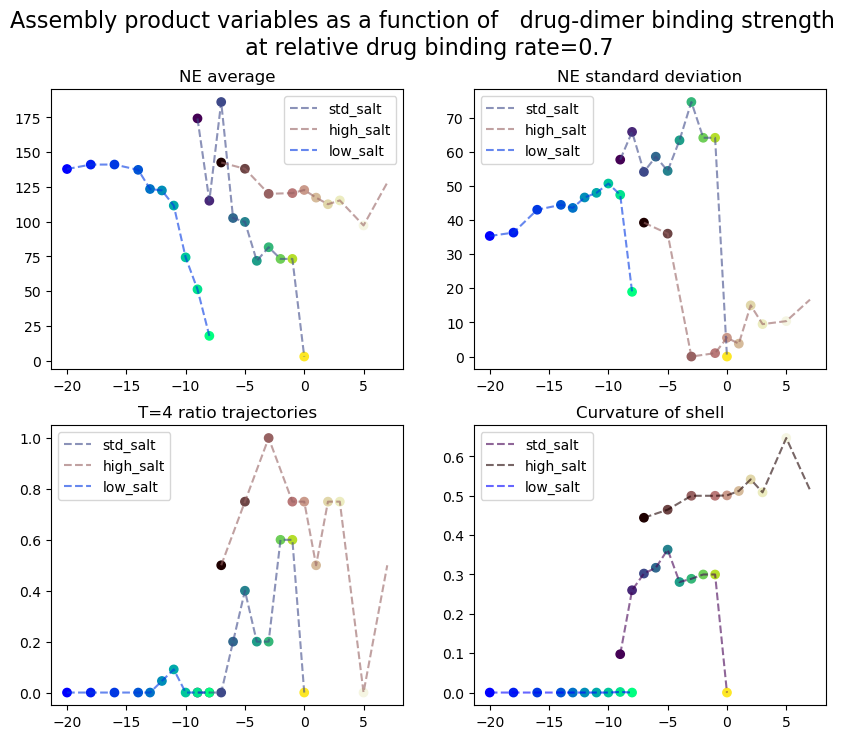

In [29]:
markerarraystd=mpl.colormaps['viridis'](np.linspace(0,1,10))
markerarrayhigh=mpl.colormaps['pink'](np.linspace(0,1,10))
markerarraylow=mpl.colormaps['winter'](np.linspace(0,1,10))

markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
fig, axs=plt.subplots(2,2,figsize=(10,8))
fig.suptitle(f'Assembly product variables as a function of   drug-dimer binding strength \n at relative drug binding rate={0.7}',fontsize=16)
std_salt=glob.glob("/scratch/09816/smritipradhan/std_salt/allEnergyFiles/*kd-0.8*.dat")
plot_std_salt=obtain_plot_df(std_salt,4.5)
high_salt=glob.glob("/scratch/09816/smritipradhan/start_pack/allEnergyFiles/*kd-0.8*.dat")
plot_high_salt=obtain_plot_df(high_salt,3.5)
low_salt=glob.glob("/scratch/09816/smritipradhan/low_salt/allEnergyFiles/*kd-0.8*.dat")
plot_low_salt=obtain_plot_df(low_salt,5.5)
plot_dataframe(plot_std_salt,'gdrug',markerarraystd,'std_salt')
plot_dataframe(plot_high_salt,'gdrug',markerarrayhigh,'high_salt')
plot_dataframe(plot_low_salt,'gdrug',markerarraylow,'low_salt')
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.savefig('binding_affinity.png')

In [5]:
filenames_all=glob.glob("stdsalt/*dat")
#print(filenames_all)
plot_heatdata=pd.DataFrame(columns=["gdrug", "kd", "NE_variable"])
for file in filenames_all:
    paras=file.split("4.5_Rgdrug-")[1]
    gdrug=paras.split("_")[0]
    #print(gdrug)
    datafile0=pd.read_csv(file)
    datafile0=datafile0.drop(datafile0[datafile0['NE']<=3].index)
    kd=paras.split("-")[1]
    kd=kd.split(".dat")[0]
    #print(kd)
    mean_edge=calc_mean(datafile0)
    mean_NE_std=calc_std(datafile0)
    NCD_hexratio=NCD_Hex_mean(datafile0)
    t4percent=T4_count(datafile0)
    new_row = [[float(gdrug),float(kd),NCD_hexratio]]
    nr=pd.DataFrame(new_row,columns=['gdrug', "kd",'NE_variable'])
    plot_heatdata = pd.concat([plot_heatdata,nr], ignore_index=True)
print(plot_heatdata.head())
#plot_heatdata=plot_heatdata.groupby('gdrug').agg({'NE_variable':'mean'}).reset_index()
#print(plot_heatdata)



   gdrug    kd  NE_variable
0   1.10  0.70     0.784981
1   0.00  0.90     0.003939
2   0.30  0.90     0.008664
3   0.01  0.90     0.005698
4   1.10  0.01     0.266923


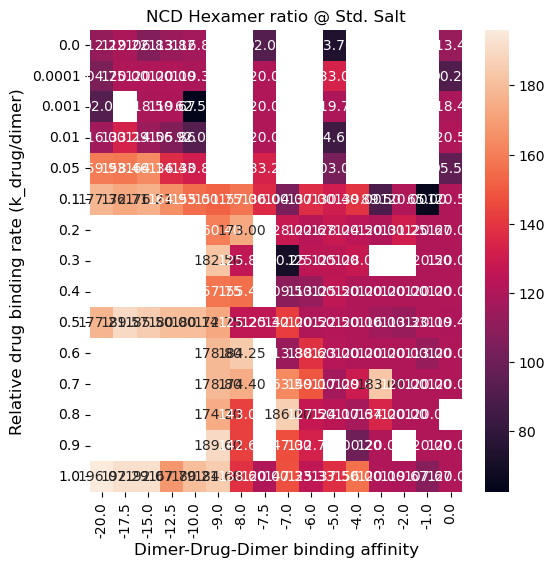

In [67]:


#plot_heatdata['kd']=plot_heatdata['gdrug']
#print(plot_heatdata)
glue = plot_heatdata.pivot(index="kd", columns="gdrug", values="NE_variable")
fig = plt.figure(figsize=(6, 6))
ax=plt.axes()
sns.heatmap(glue,ax=ax,xticklabels=1, yticklabels=1,annot=True,annot_kws={"fontsize":10},fmt='.2f')
ax.set_title('NCD Hexamer ratio @ Std. Salt',fontsize=12)
ax.set_ylabel('Relative drug binding rate (k_drug/dimer)',fontsize=12)
ax.set_xlabel('Dimer-Drug-Dimer binding affinity',fontsize=12)
plt.savefig('std_dev_std_salt.png')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-1.0.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-2.0.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-0.3.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-0.01.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-0.1.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-0.5.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-0.001.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-0.9.dat', 'highsalt/SE-DMU--3.5_Rgdrug-0.9_kd-0.7.dat']
128
128
128
128
128
128
128
128
128
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
   gdrug     kd    edgemean    calcstd   edgestd   t4ratio  NCDHexratio  \
6    0.9  0.001  132.085938  26.105488  2.307421  0.632812     0.078459   
3    0.9  0.010  136.312500  39.102279  3.456186  0.773438     0.059752   
4    0.9  0.100  148.296875  52.567671  4.646370  0.679688     0.097004   
2    0.9  0.300  147.812500  48.324323  4.271307  0.632812     0.111081   
5    0.9  0.500  166.843750  57.747269  5.104186  0.453125     0.179554   

   NCDHexstd  
6   0.008952  
3   0.009526  


Text(0, 0.5, '$\\langle Ndimer \\rangle$')

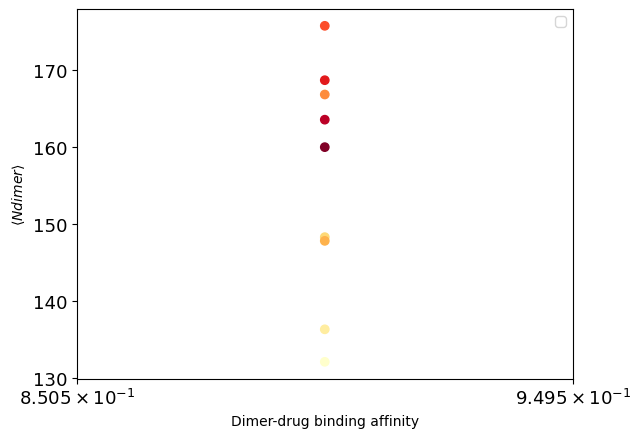

In [46]:
highsaltfiles=glob.glob("highsalt/*gdrug-0.9*.dat")
print(highsaltfiles)
stdsaltfiles=glob.glob("stdsalt/*gdrug-0.9*.dat")
plot_highdata=pd.DataFrame(columns=["gdrug", "kd", "edgemean","calcstd","edgestd","t4ratio","NCDHexratio","NCDHexstd"])
nassemble=[]
for file in highsaltfiles:
    paras=file.split("3.5_Rgdrug-")[1]
    gdrug=paras.split("_")[0]
    #print(gdrug)
    datafile0=pd.read_csv(file)
    datafile0=datafile0.drop(datafile0[datafile0['NE']<=3].index)
    kd=paras.split("-")[1]
    kd=kd.split(".dat")[0]
    #print(kd)
    mean_edge=calc_mean(datafile0)
    mean_NE_std=calc_std(datafile0)/(np.sqrt(len(datafile0['NE'])))
    NCD_hexratio=NCD_Hex_mean(datafile0)
    NCD_hexratiostd=NCD_Hex_std(datafile0)/(np.sqrt(len(datafile0['NE'])))
    print(len(datafile0['NE']))
    t4percent=T4_count(datafile0)
    calc_std2=calc_std(datafile0)
    new_row = [[float(gdrug),float(kd),mean_edge,calc_std2,mean_NE_std,t4percent,NCD_hexratio,NCD_hexratiostd]]
    nr=pd.DataFrame(new_row,columns=['gdrug', "kd",'edgemean', "calcstd",'edgestd','t4ratio','NCDHexratio','NCDHexstd'])
    plot_highdata = pd.concat([plot_highdata,nr], ignore_index=True)
    nassemble.append(len(datafile0['NE'])/128)
print(nassemble)
print(np.asarray(nassemble).mean())
plot_lowdata=pd.DataFrame(columns=["gdrug", "kd", "edgemean","calcstd","edgestd","t4ratio","NCDHexratio","NCDHexstd"])
#nassemble=nfiles+1
for file in stdsaltfiles:
    paras=file.split("4.5_Rgdrug-")[1]
    gdrug=paras.split("_")[0]
    #print(gdrug)
    datafile0=pd.read_csv(file)
    datafile0=datafile0.drop(datafile0[datafile0['NE']<=3].index)
    kd=paras.split("-")[1]
    kd=kd.split(".dat")[0]
    #print(kd)
    mean_edge=calc_mean(datafile0)
    mean_NE_std=calc_std(datafile0)/(np.sqrt(len(datafile0['NE'])))
    NCD_hexratio=NCD_Hex_mean(datafile0)
    NCD_hexratiostd=NCD_Hex_std(datafile0)/(np.sqrt(len(datafile0['NE'])))
    t4percent=T4_count(datafile0)
    calc_std2=calc_std(datafile0)
    new_row = [[float(gdrug),float(kd),mean_edge,calc_std2,mean_NE_std,t4percent,NCD_hexratio,NCD_hexratiostd]]
    nr=pd.DataFrame(new_row,columns=['gdrug', "kd",'edgemean','calcstd','edgestd','t4ratio','NCDHexratio','NCDHexstd'])
    plot_lowdata= pd.concat([plot_lowdata,nr], ignore_index=True)
plt.xscale("symlog")
plot_lowdata=plot_lowdata.sort_values('kd')
plot_highdata=plot_highdata.sort_values('kd')
print(plot_highdata.head())
print(plot_lowdata.head())
#plt.xticks(plot_heatdata['kd'])
markerarraystd=mpl.colormaps['viridis'](np.linspace(0,1,10))
markerarrayhigh=mpl.colormaps['YlOrRd'](np.linspace(0,1,9))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
#for  xp, yp, m in zip(plot_heatdata['kd'], plot_heatdata['edgemean'], markers):
#    plt.plot(xp,yp,c=m,label=f'kdd={xp}')
plt.scatter(plot_highdata['gdrug'],plot_highdata['edgemean'],color=markerarrayhigh,alpha=1.0)
#plt.errorbar(plot_highdata['kd'],plot_highdata['edgemean'],yerr=plot_highdata['edgestd'],fmt='',marker='',linestyle='',color='r',alpha=0.2)
#plt.colorbar()
#plt.scatter(plot_lowdata['kd'],plot_lowdata['t4ratio'],color=markerarraystd,alpha=1.0)
#plt.errorbar(plot_lowdata['kd'],plot_lowdata['edgemean'],yerr=plot_lowdata['edgestd'],fmt='',marker='',linestyle='',color='g',alpha=0.3)
#plt.colorbar()
#plt.plot(plot_lowdata['kd'],plot_lowdata['t4ratio'],'--k',label='standard salt conc.',alpha=0.3,linewidth=3)
#plt.plot(plot_highdata['kd'],plot_highdata['edgestd'],'-r',label='high salt conc.',alpha=0.2,linewidth=3)
plt.legend()
plt.xlabel('Dimer-drug binding affinity')
plt.ylabel(r'$\langle Ndimer \rangle$')



In [47]:
fig, axs=plt.subplots(2,2,figsize=(10,8))
fig.suptitle(f'Assembly product variables as a function of  relative subunit-drug binding rate \n at subunit-drug binding affinity={gdrug}',fontsize=16)
#axs[0].set_xscale('symlog')


axs[0,0].scatter(plot_highdata['kd'],plot_highdata['edgemean'],color=markerarrayhigh,alpha=1.0)
#plt.colorbar()
axs[0,0].errorbar(plot_highdata['kd'],plot_highdata['edgemean'],yerr=plot_highdata['edgestd'],fmt='',marker='',linestyle='',color='r',alpha=0.5)
axs[0,0].scatter(plot_lowdata['kd'],plot_lowdata['edgemean'],color=markerarraystd,alpha=1.0)
axs[0,0].errorbar(plot_lowdata['kd'],plot_lowdata['edgemean'],yerr=plot_lowdata['edgestd'],fmt='',marker='',linestyle='',color='g',alpha=0.5)
#plt.colorbar()
axs[0,0].plot(plot_lowdata['kd'],plot_lowdata['edgemean'],'--g',label='standard salt conc.',alpha=0.3,linewidth=3.5)
axs[0,0].plot(plot_highdata['kd'],plot_highdata['edgemean'],'-r',label='high salt conc.',alpha=0.2,linewidth=3.5)
axs[0,0].set_ylabel(r'$\langle Nsize \rangle$',fontsize=14)
axs[0,0].set_xlabel('Relative subunit-drug binding rate',fontsize=14)
#axs[0].set_xlabel('Dimer-drug binding rate')
axs[0,0].legend()
#axs[0,1].set_xscale('symlog')

axs[0,1].scatter(plot_highdata['kd'],plot_highdata['calcstd'],color=markerarrayhigh,alpha=1.0)
#plt.colorbar()
axs[0,1].scatter(plot_lowdata['kd'],plot_lowdata['calcstd'],color=markerarraystd,alpha=1.0)
#plt.colorbar()
axs[0,1].plot(plot_lowdata['kd'],plot_lowdata['calcstd'],'--k',label='standard salt conc.',alpha=0.3,linewidth=3.5)
axs[0,1].plot(plot_highdata['kd'],plot_highdata['calcstd'],'-r',label='high salt conc.',alpha=0.2,linewidth=3.5)
axs[0,1].set_ylabel('Std. deviation of Nsize',fontsize=14)
axs[0,1].set_xlabel('Relative subunit-drug binding affinity',fontsize=14)
axs[0,1].legend()
#axs[1].set_xscale('symlog')
axs[1,0].scatter(plot_highdata['kd'],plot_highdata['t4ratio'],color=markerarrayhigh,alpha=1.0)
#plt.colorbar()
axs[1,0].scatter(plot_lowdata['kd'],plot_lowdata['t4ratio'],color=markerarraystd,alpha=1.0)
#plt.colorbar()
axs[1,0].plot(plot_lowdata['kd'],plot_lowdata['t4ratio'],'--k',label='standard salt conc.',alpha=0.3,linewidth=3.5)
axs[1,0].plot(plot_highdata['kd'],plot_highdata['t4ratio'],'-r',label='high salt conc.',alpha=0.2,linewidth=3.5)
axs[1,0].set_ylabel('T=4 ratio',fontsize=14)
axs[1,0].set_xlabel('Relative subnit-drug binding affinity',fontsize=14)
#axs[1].set_xlabel('Dimer-drug binding rate')
axs[1,0].legend()

#axs[2].set_xscale('symlog')
axs[1,1].scatter(plot_highdata['kd'],plot_highdata['NCDHexratio'],color=markerarrayhigh,alpha=1.0)
#plt.colorbar()
axs[1,1].errorbar(plot_highdata['kd'],plot_highdata['NCDHexratio'],yerr=plot_highdata['NCDHexstd'],fmt='',marker='',linestyle='',color='r',alpha=0.5)
axs[1,1].scatter(plot_lowdata['kd'],plot_lowdata['NCDHexratio'],color=markerarraystd,alpha=1.0)
axs[1,1].errorbar(plot_lowdata['kd'],plot_lowdata['NCDHexratio'],yerr=plot_lowdata['NCDHexstd'],fmt='',marker='',linestyle='',color='g',alpha=0.5)

#plt.colorbar()
axs[1,1].plot(plot_lowdata['kd'],plot_lowdata['NCDHexratio'],'--g',label='standard salt conc.',alpha=0.3,linewidth=3.5)
axs[1,1].plot(plot_highdata['kd'],plot_highdata['NCDHexratio'],'-r',label='high salt conc.',alpha=0.2,linewidth=3.5)
axs[1,1].set_ylabel(r'CD hexameric dimer ratio',fontsize=14)
axs[1,1].set_xlabel('Relative subunit-drug binding affinity',fontsize=14)
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
axs[1,1].legend()
fig.savefig('gdd_0.5.png')



SyntaxError: unterminated string literal (detected at line 15) (3158196338.py, line 15)

In [11]:
import ovito

ModuleNotFoundError: No module named 'ovito'